In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn,tf,keras:
    print(module.__name__,module.__version__)
    

2.0.0
sys.version_info(major=3, minor=6, micro=2, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.18.0
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
## 实现步骤：
## 1.载入数据
## 2.数据预处理-
##  2.1 预先生产词表处理
##  2.2 加载词表
##...
## 5.optimizer & loss
## 6.train step  --> train
## 7.Evaluate and Visualize

In [4]:
%%time
## 1.载入数据
data_path='data\\news-commentary-v14.en-zh.tsv'

def create_dataset(path,num_examples):
    lines = open(path,encoding='UTF-8').read().strip().split('\n')
#     word_pairs = [ [ preprocess_sentence(w,index) for index,w in enumerate(line.split('\t')) ] for line in lines[:num_examples]]
    word_pairs = [ [ w for index,w in enumerate(line.split('\t')) ] for line in lines[:num_examples]]
    print('len word_pairs:',len(word_pairs))
    return zip(*word_pairs)

en,cn = create_dataset(data_path,None)# 加载全部数据


len word_pairs: 320331
Wall time: 1.41 s


In [5]:
%%time
## 1.载入数据 为了做词表时使用=== 使用tfds 的SubwordTextEncoder无需事先切词 
# data_path='data\\news-commentary-v14.en-zh.tsv'

# def create_dataset(path,num_examples):
#     lines = open(path,encoding='UTF-8').read().strip().split('\n')
#     word_pairs = [ [ w for index,w in enumerate(line.split('\t')) ] for line in lines[:num_examples]]
#     print('len word_pairs:',len(word_pairs))
#     return zip(*word_pairs)

# en,cn = create_dataset(data_path,None)

Wall time: 0 ns


In [6]:
%%time
## 加载构建中文词表
import tensorflow_datasets as tfds

vocab_filename="./cn_vocab.txt"
# Build
# cn_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
#     cn, target_vocab_size= 2**13)   ## 首次执政，执行一个多小时
# cn_tokenizer.save_to_file(vocab_filename)

# Load #构建词表
cn_tokenizer = tfds.features.text.SubwordTextEncoder.load_from_file(vocab_filename)
print("cn_tokkenizer:",cn_tokenizer)


cn_tokkenizer: <SubwordTextEncoder vocab_size=8266>
Wall time: 208 ms


In [7]:
%%time
## 加载构建英文词表
import tensorflow_datasets as tfds

vocab_filename2="./en_vocab.txt"
# Build
# en_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
#     en, target_vocab_size= 2**13)## 首次执政
# en_tokenizer.save_to_file(vocab_filename2)

#构建词表
en_tokenizer = tfds.features.text.SubwordTextEncoder.load_from_file(vocab_filename2)
print("en_tokenizer:",en_tokenizer)

en_tokenizer: <SubwordTextEncoder vocab_size=8161>
Wall time: 29.9 ms


In [8]:
## 测试词表装ID
sample_string = "Transformer is awesome."

tokenized_string = en_tokenizer.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))

origin_string = en_tokenizer.decode(tokenized_string)
print('The original string is {}'.format(origin_string))

assert origin_string == sample_string

for token in tokenized_string:
    print('{} --> "{}"'.format(token, en_tokenizer.decode([token])))
    
sample_string_cn = "随着经济危机不断加深和蔓延，"

tokenized_string = cn_tokenizer.encode(sample_string_cn)
print('Tokenized string is {}'.format(tokenized_string))

origin_string = cn_tokenizer.decode(tokenized_string)
print('The original string is {}'.format(origin_string))

assert origin_string == sample_string_cn

for token in tokenized_string:
    print('{} --> "{}"'.format(token, cn_tokenizer.decode([token])))

Tokenized string is [2756, 470, 9, 3176, 146, 1741, 7951]
The original string is Transformer is awesome.
2756 --> "Trans"
470 --> "former "
9 --> "is "
3176 --> "aw"
146 --> "es"
1741 --> "ome"
7951 --> "."
Tokenized string is [361, 4166, 577, 7639, 4, 3700, 1]
The original string is 随着经济危机不断加深和蔓延，
361 --> "随着"
4166 --> "经济危机"
577 --> "不断"
7639 --> "加深"
4 --> "和"
3700 --> "蔓延"
1 --> "，"


In [9]:
## # 训练集与验证集的拆分
from sklearn.model_selection import train_test_split


input_train_cn,input_val_cn,target_train_en,target_val_en = train_test_split(cn,en,test_size=0.2)
print(target_train_en[1])
print(input_train_cn[1])
len(input_train_cn),len(target_train_en),len(input_val_cn),len(target_val_en)


In fact, very few (if any) of the African countries that signed the 2001 Abuja Declaration to allocate 15% of their budget to health have been able to do so.
事实上，在2001年签署了《阿布贾宣言》的非洲国家还没有几个（如果有的话）能兑现将本国15％的预算用于医疗保健的宣言内容。


(256264, 256264, 64067, 64067)

In [10]:
%%time
## 2.数据预处理----》dataset
buffer_size = len(input_train_cn)
batch_size = 64
max_length = 180

## 转码后，加上，前后缀
def encode_to_subword(cn_sentence, en_sentence):
    cn_sequence = [cn_tokenizer.vocab_size] \
    + cn_tokenizer.encode(cn_sentence.numpy()) \
    + [cn_tokenizer.vocab_size + 1]
    en_sequence = [en_tokenizer.vocab_size] \
    + en_tokenizer.encode(en_sentence.numpy()) \
    + [en_tokenizer.vocab_size + 1]
    return cn_sequence, en_sequence

def filter_by_max_length(cn, en):
    return tf.logical_and(tf.size(cn) <= max_length,
                          tf.size(en) <= max_length)

def tf_encode_to_subword(cn_sentence, en_sentence):
    return tf.py_function(encode_to_subword,
                          [cn_sentence, en_sentence],
                          [tf.int64, tf.int64])


train_examples = tf.data.Dataset.from_tensor_slices((input_train_cn, target_train_en))
train_dataset = train_examples.map(tf_encode_to_subword)
train_dataset = train_dataset.filter(filter_by_max_length)
train_dataset = train_dataset.shuffle(
    buffer_size).padded_batch(
    batch_size, padded_shapes=([-1], [-1]))


val_examples = tf.data.Dataset.from_tensor_slices((input_val_cn, target_val_en))
valid_dataset = val_examples.map(tf_encode_to_subword)
valid_dataset = valid_dataset.filter(
    filter_by_max_length).padded_batch(
    batch_size, padded_shapes=([-1], [-1]))
print(train_dataset)
for cn_batch, en_batch in train_dataset.take(2):
    print(cn_batch.shape, en_batch.shape)




<PaddedBatchDataset shapes: ((None, None), (None, None)), types: (tf.int64, tf.int64)>
(64, 81) (64, 86)
(64, 68) (64, 78)
Wall time: 1min 33s


In [12]:
## 5.optimizer & loss
## 6.train step  --> train
## 7.Evaluate and Visualize

In [13]:
## 初始化模型前先定义一些超参数
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = cn_tokenizer.vocab_size + 2
target_vocab_size = en_tokenizer.vocab_size + 2

dropout_rate = 0.1

from commonUtil.transformer.transformer import Transformer

#### 模型构建##
transformer = Transformer(num_layers,
                          input_vocab_size,
                          target_vocab_size,
                          max_length,
                          d_model, num_heads, dff, dropout_rate)

In [15]:
## 5.optimizer & loss
from commonUtil.transformer.learn_rate import CustomizedSchedule,loss_function
learning_rate = CustomizedSchedule(d_model)
optimizer = keras.optimizers.Adam(learning_rate,
                                  beta_1 = 0.9,
                                  beta_2 = 0.98,
                                  epsilon = 1e-9)

train_loss = keras.metrics.Mean(name='train_loss')
train_accuracy = keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [55]:
checkpoint_dir = './cn2en_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 model=transformer)
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)
is_checkpoint=tf.train.latest_checkpoint(checkpoint_dir)
print(is_checkpoint)
if tf.train.latest_checkpoint(checkpoint_dir):
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

./cn2en_checkpoints\ckpt-2009


In [53]:
## 6.train step  --> train
from commonUtil.transformer.mask import create_masks

@tf.function(experimental_relax_shapes=True)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask \
        = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, True,
                                     encoder_padding_mask,
                                     decoder_mask,
                                     encoder_decoder_padding_mask)
        loss = loss_function(tar_real, predictions)  ## 计算损失函数

    gradients = tape.gradient(loss, transformer.trainable_variables) ## 计算梯度
    optimizer.apply_gradients(
        zip(gradients, transformer.trainable_variables))   ### 梯度应用到变量去
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [54]:
%%time
epochs=20
for epoch in range(epochs):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for (batch,(inp,tar)) in enumerate(train_dataset):
        train_step(inp,tar)
        if batch % 100 ==0:
#             print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(train_accuracy.result()))
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(),
                train_accuracy.result()))
            checkpoint.save(file_prefix = checkpoint_prefix)
    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch+1,train_loss.result(),train_accuracy.result()))
    print('Time take for 1 epoch: {} secconds \n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.8449 Accuracy 0.2506
Epoch 1 Batch 100 Loss 0.8051 Accuracy 0.2390
Epoch 1 Batch 200 Loss 0.7951 Accuracy 0.2362
Epoch 1 Batch 300 Loss 0.7990 Accuracy 0.2355
Epoch 1 Batch 400 Loss 0.8049 Accuracy 0.2365
Epoch 1 Batch 500 Loss 0.8081 Accuracy 0.2381
Epoch 1 Batch 600 Loss 0.8115 Accuracy 0.2390
Epoch 1 Batch 700 Loss 0.8098 Accuracy 0.2377
Epoch 1 Batch 800 Loss 0.8088 Accuracy 0.2372
Epoch 1 Batch 900 Loss 0.8076 Accuracy 0.2365
Epoch 1 Batch 1000 Loss 0.8079 Accuracy 0.2364
Epoch 1 Batch 1100 Loss 0.8070 Accuracy 0.2357
Epoch 1 Batch 1200 Loss 0.8079 Accuracy 0.2357
Epoch 1 Batch 1300 Loss 0.8083 Accuracy 0.2358
Epoch 1 Batch 1400 Loss 0.8096 Accuracy 0.2361
Epoch 1 Batch 1500 Loss 0.8094 Accuracy 0.2355
Epoch 1 Batch 1600 Loss 0.8096 Accuracy 0.2355
Epoch 1 Batch 1700 Loss 0.8109 Accuracy 0.2358
Epoch 1 Batch 1800 Loss 0.8118 Accuracy 0.2359
Epoch 1 Batch 1900 Loss 0.8124 Accuracy 0.2358
Epoch 1 Batch 2000 Loss 0.8131 Accuracy 0.2361
Epoch 1 Batch 2100 Loss 0

KeyboardInterrupt: 

In [43]:
"""
eg: A B C D -> E F G H.
Train: A B C D, E F G -> F G H
Eval:  A B C D -> E
       A B C D, E -> F
       A B C D, E F -> G
       A B C D, E F G -> H
"""
# from commonUtil.transformer.evaluate import evaluate,plot_encoder_decoder_attention
def evaluate(inp_sentence,x_tokenizer,y_tokenizer,max_length,transformer):
    input_id_sentence = [x_tokenizer.vocab_size] \
                        + x_tokenizer.encode(inp_sentence) + [x_tokenizer.vocab_size + 1]   # 文本转换为ID
    # encoder_input.shape: (1, input_sentence_length)
    encoder_input = tf.expand_dims(input_id_sentence, 0)

    # decoder_input.shape: (1, 1)
    decoder_input = tf.expand_dims([y_tokenizer.vocab_size], 0)

    for i in range(max_length):
        encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask \
            = create_masks(encoder_input, decoder_input)
        # predictions.shape: (batch_size, output_target_len, target_vocab_size)
        predictions, attention_weights = transformer(
            encoder_input,
            decoder_input,
            False,
            encoder_padding_mask,
            decoder_mask,
            encoder_decoder_padding_mask)
        # predictions.shape: (batch_size, target_vocab_size)
        predictions = predictions[:, -1, :]

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1),
                               tf.int32)

        if tf.equal(predicted_id, y_tokenizer.vocab_size + 1):# 判断是否等于end id
            return tf.squeeze(decoder_input, axis=0), attention_weights

        decoder_input = tf.concat([decoder_input, [predicted_id]],
                                  axis=-1)
    return tf.squeeze(decoder_input, axis=0), attention_weights


def plot_encoder_decoder_attention(attention, input_sentence,
                                   result, layer_name,x_tokenizer,y_tokenizer):
    fig = plt.figure(figsize=(16, 8))

    input_id_sentence = x_tokenizer.encode(input_sentence)

    # attention.shape before squeeze: (1, num_heads, tar_len, input_len)
    # attention.shape after squeeze: (num_heads, tar_len, input_len)
    attention = tf.squeeze(attention[layer_name], axis=0)
#     plt.rcParams['font.family']='AR PL UKai CN'
    plt.rcParams["font.family"]="STSong" 
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head + 1)

        ax.matshow(attention[head][:-1, :])

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(input_id_sentence) + 2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result) - 1.5, -0.5)

        ax.set_xticklabels(
            ['<start>'] + [x_tokenizer.decode([i]) for i in input_id_sentence] + ['<end>'],
            fontdict=fontdict, rotation=90)
        ax.set_yticklabels(
            [y_tokenizer.decode([i]) for i in result if i < y_tokenizer.vocab_size],
            fontdict=fontdict)
        ax.set_xlabel('Head {}'.format(head + 1))
    plt.tight_layout()
    plt.show()

In [44]:
def translate(input_sentence, layer_name=''):
    result, attention_weights = evaluate(input_sentence,cn_tokenizer,en_tokenizer,max_length,transformer)

    predicted_sentence = en_tokenizer.decode(
        [i for i in result if i < en_tokenizer.vocab_size])

    print("Input: {}".format(input_sentence))
    print("Predicted translation: {}".format(predicted_sentence))

    if layer_name:
        plot_encoder_decoder_attention(attention_weights, input_sentence,
                                       result, layer_name,cn_tokenizer,en_tokenizer)

In [45]:
translate('我是谁？')

Input: 我是谁？
Predicted translation: Who Is I to be?


In [46]:
translate('1929年还是1989年?')

Input: 1929年还是1989年?
Predicted translation: 1929 or 1989?


In [47]:
translate('然而，作为地域战略学家，无论是从政治意义还是从经济意义上，让我自然想到的年份是1989年。')

Input: 然而，作为地域战略学家，无论是从政治意义还是从经济意义上，让我自然想到的年份是1989年。
Predicted translation: But, as a regional strategist, whether political significance or economic sense, I would have thought to be in 1989.


In [48]:
translate('今天的天气很好！')

Input: 今天的天气很好！
Predicted translation: Today’s weather is well!


In [49]:
translate(u'这是我的生活。')

Input: 这是我的生活。
Predicted translation: That is my life.


Input: 这样表现不是很好
Predicted translation: That is Not Well


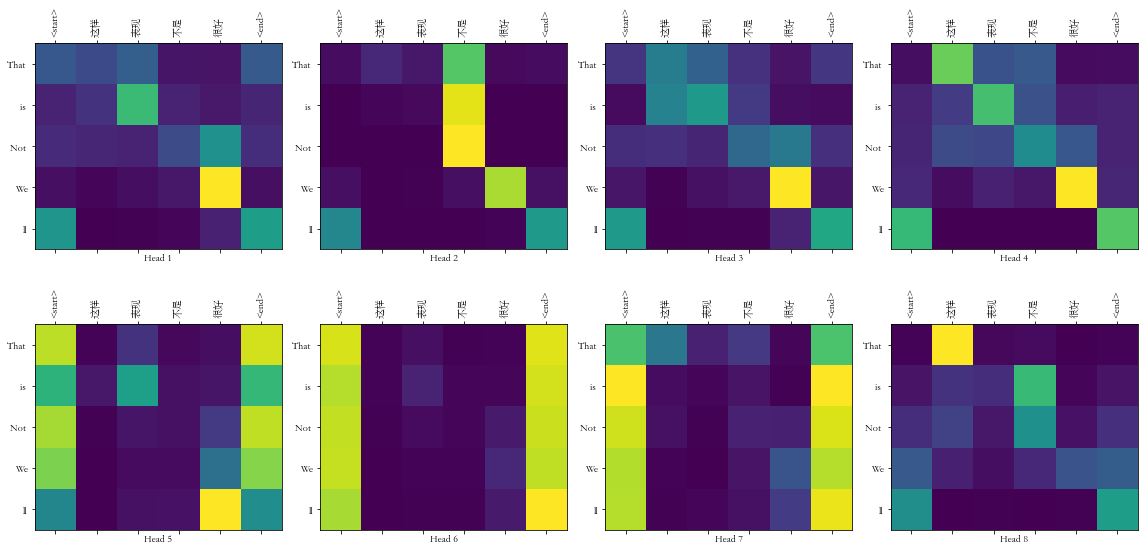

In [51]:
translate(u'这样表现不是很好',
          layer_name = 'decoder_layer4_att2')

Input: 这是我的生活。
Predicted translation: That is my life.


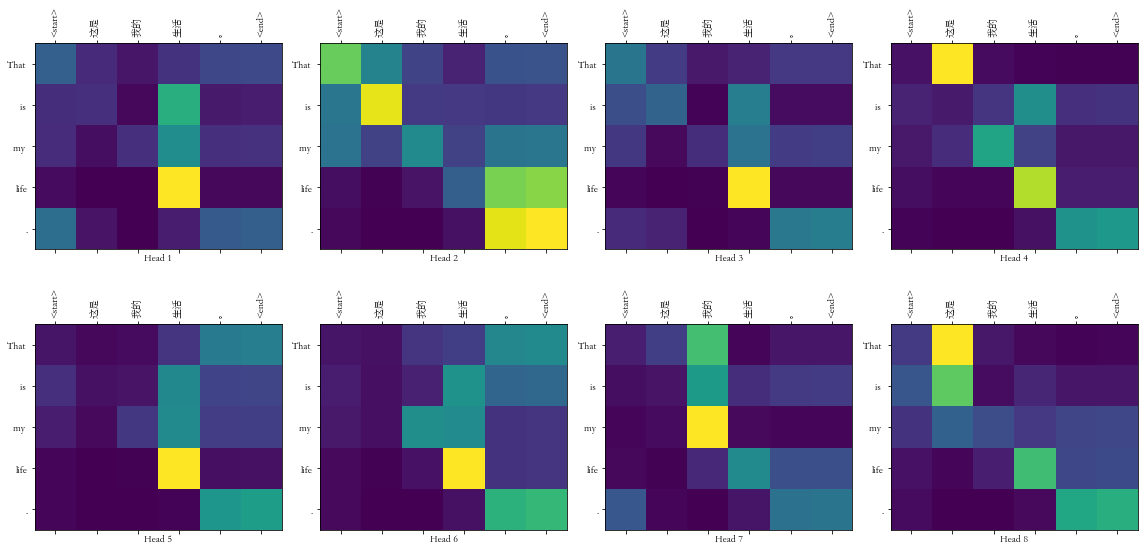

In [50]:
translate(u'这是我的生活。',layer_name = 'decoder_layer4_att2')